Data Loading in Colab

In [1]:
import pandas as pd
import numpy as np

# Load dataset from local or Google Drive path
df = pd.read_csv("/content/diabetic_data.csv")
print("Dataset loaded with shape:", df.shape)



Dataset loaded with shape: (100227, 50)


Data Preprocessing with Pandas

In [2]:
df.replace("?", np.nan, inplace=True)

df.drop(columns=["weight", "payer_code", "medical_specialty"], inplace=True, errors='ignore')

expired_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(expired_codes)].copy()

admission_type_map = {
    1: "Emergency", 2: "Urgent", 3: "Elective", 4: "Newborn",
    5: "Not Available", 6: "NULL", 7: "Trauma Center", 8: "Not Mapped"
}
discharge_disposition_map = {
    1: "Discharged to home", 2: "Short-term hospital", 3: "SNF", 4: "ICF", 5: "Another facility",
    6: "Home health", 7: "Left AMA", 8: "Home/org care", 9: "Readmitted",
    11: "Expired", 13: "Hospice / Home", 14: "Hospice / Facility", 20: "Expired"
}
admission_source_map = {
    1: "Physician Referral", 2: "Clinic Referral", 3: "HMO Referral",
    4: "Transfer from hospital", 5: "Transfer from SNF", 6: "Other facility",
    7: "Emergency Room", 8: "Court/Law", 9: "Not Available"
}

df['admission_type'] = df['admission_type_id'].replace(admission_type_map)
df['discharge_disposition'] = df['discharge_disposition_id'].replace(discharge_disposition_map)
df['admission_source'] = df['admission_source_id'].replace(admission_source_map)

df.drop(['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

df['readmit_30'] = np.where(df['readmitted'] == "<30", 1, 0)

df.drop(columns=["encounter_id"], inplace=True, errors='ignore')
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=constant_cols, inplace=True)

df.dropna(subset=["race", "gender", "age"], inplace=True)

print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (96399, 45)


In [3]:
print("Columns in dataset after cleaning:", df.columns.tolist())
print("Sample of unique values in key columns:")
print("  - race:", df['race'].unique())
print("  - gender:", df['gender'].unique())
print("  - age:", sorted(df['age'].unique()))
print("  - readmit_30 (target) distribution:\n", df['readmit_30'].value_counts(normalize=True))



Columns in dataset after cleaning: ['patient_nbr', 'race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'admission_type', 'discharge_disposition', 'admission_source', 'readmit_30']
Sample of unique values in key columns:
  - race: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
  - gender: ['Female' 'Male' 'Unknown/Invalid']
  - age: ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)

Relational Database Schema (SQLite)

In [4]:
import sqlite3
import pandas as pd


conn = sqlite3.connect("diabetes_readmissions.db")


patients_df = df[["patient_nbr", "race", "gender", "age"]].drop_duplicates(subset="patient_nbr").copy()
patients_df.rename(columns={"patient_nbr": "patient_id"}, inplace=True)
patients_df.to_sql("Patients", conn, if_exists="replace", index=False)
print("Loaded Patients table:", patients_df.shape)


encounters_df = df.copy()
encounters_df.drop(columns=["race", "gender", "age", "readmitted"], inplace=True, errors='ignore')
encounters_df.rename(columns={"patient_nbr": "patient_id"}, inplace=True)

for col in encounters_df.columns:
    if encounters_df[col].apply(lambda x: isinstance(x, pd.Interval)).any():
        encounters_df[col] = encounters_df[col].astype(str)

encounters_df.to_sql("Encounters", conn, if_exists="replace", index=False)
print("Loaded Encounters table:", encounters_df.shape)


cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("SQLite tables:", [x[0] for x in cur.fetchall()])




Loaded Patients table: (67778, 4)
Loaded Encounters table: (96399, 41)
SQLite tables: ['Patients', 'Encounters']


Querying the Database with SQL

In [5]:
# Query 1: Readmission counts
query = """
SELECT readmit_30, COUNT(*) as count
FROM Encounters
GROUP BY readmit_30;
"""
result = pd.read_sql_query(query, conn)
print("\nReadmission counts:\n", result)

# Query 2: Average medications and hospital time by readmission
query = """
SELECT readmit_30,
       AVG(num_medications) as avg_medications,
       AVG(time_in_hospital) as avg_time_in_hosp
FROM Encounters
GROUP BY readmit_30;
"""
print("\nAverage meds/time by readmission:\n", pd.read_sql_query(query, conn))

# Query 3: Readmission rate by age group using join
query = """
SELECT P.age,
       COUNT(E.readmit_30) as total_encounters,
       SUM(E.readmit_30) as readmit_30_count,
       (1.0 * SUM(E.readmit_30) / COUNT(E.readmit_30)) as readmit_rate
FROM Encounters E
JOIN Patients P ON E.patient_id = P.patient_id
GROUP BY P.age
ORDER BY P.age;
"""
age_readmit = pd.read_sql_query(query, conn)
print("\nReadmission rate by age:\n", age_readmit)


Readmission counts:
    readmit_30  count
0           0  85398
1           1  11001

Average meds/time by readmission:
    readmit_30  avg_medications  avg_time_in_hosp
0           0        15.854294          4.345851
1           1        16.906281          4.775202

Readmission rate by age:
         age  total_encounters  readmit_30_count  readmit_rate
0    [0-10)               160                 3      0.018750
1   [10-20)               708                58      0.081921
2   [20-30)              1610               226      0.140373
3   [30-40)              3709               413      0.111351
4   [40-50)              9512              1055      0.110913
5   [50-60)             16664              1634      0.098056
6   [60-70)             21436              2441      0.113874
7   [70-80)             24618              2971      0.120684
8   [80-90)             15665              1941      0.123907
9  [90-100)              2317               259      0.111782


Exploratory Data Analysis (EDA)

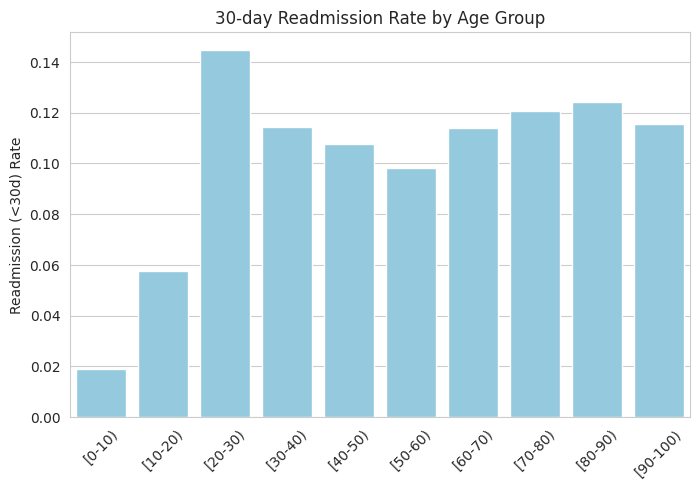

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

age_groups = df['age'].unique()
age_groups.sort()
readmit_rates = []
for age in age_groups:
    group = df[df['age'] == age]
    rate = group['readmit_30'].mean()
    readmit_rates.append(rate)

plt.figure(figsize=(8,5))
sns.barplot(x=age_groups, y=readmit_rates, color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Readmission (<30d) Rate")
plt.title("30-day Readmission Rate by Age Group")
plt.show()


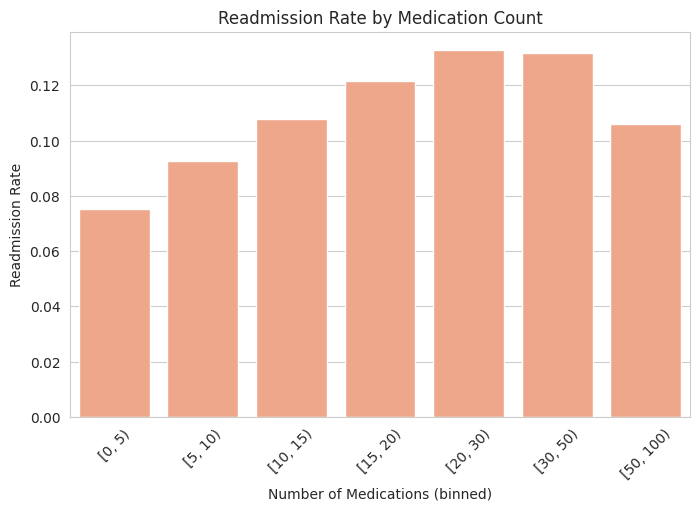

In [7]:
# Readmission vs. Number of Medications
df['med_bins'] = pd.cut(df['num_medications'], bins=[0,5,10,15,20,30,50,100], right=False)
med_readmit = df.groupby('med_bins', observed=True)['readmit_30'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='med_bins', y='readmit_30', data=med_readmit, color="lightsalmon")
plt.xticks(rotation=45)
plt.xlabel("Number of Medications (binned)")
plt.ylabel("Readmission Rate")
plt.title("Readmission Rate by Medication Count")
plt.show()


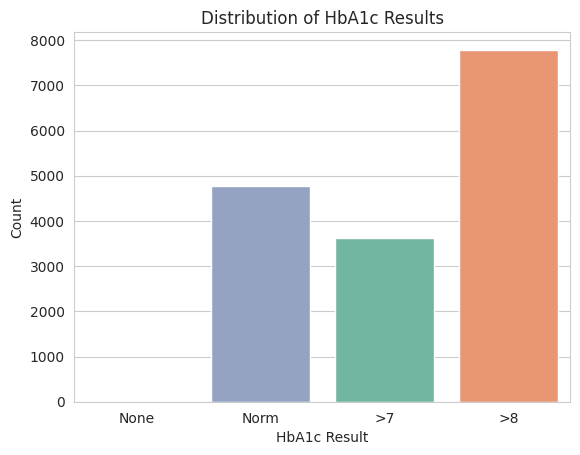

A1Cresult
>8      7789
Norm    4777
>7      3626
Name: count, dtype: int64


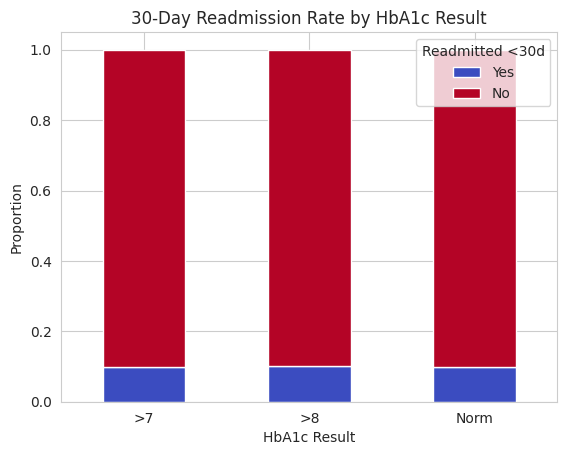

In [8]:
# Bar plot: distribution of HbA1c results
sns.countplot(data=df, x='A1Cresult', hue='A1Cresult', order=['None', 'Norm', '>7', '>8'], palette='Set2', legend=False)
plt.title("Distribution of HbA1c Results")
plt.xlabel("HbA1c Result")
plt.ylabel("Count")
plt.show()

print(df['A1Cresult'].value_counts())

df['readmit_30_label'] = df['readmit_30'].map({0: "No", 1: "Yes"})

hb_readmit = df.groupby(['A1Cresult', 'readmit_30_label']).size().unstack().fillna(0)
hb_readmit_percent = hb_readmit.div(hb_readmit.sum(axis=1), axis=0)

# Stacked bar plot of readmission proportion per HbA1c category
hb_readmit_percent[['Yes', 'No']].plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title("30-Day Readmission Rate by HbA1c Result")
plt.xlabel("HbA1c Result")
plt.ylabel("Proportion")
plt.legend(title="Readmitted <30d")
plt.xticks(rotation=0)
plt.show()


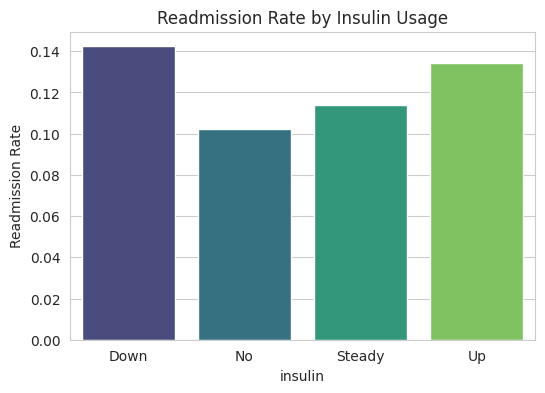

Readmission rate with insulin: 0.12460919180866031
Readmission rate without insulin: 0.102248855670787


In [9]:
# Readmission vs. Insulin Use
insulin_readmit = df.groupby('insulin')['readmit_30'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='insulin', y='readmit_30', hue='insulin', data=insulin_readmit, palette="viridis", legend=False)
plt.ylabel("Readmission Rate")
plt.title("Readmission Rate by Insulin Usage")
plt.show()

df['insulin_used'] = (df['insulin'] != 'No').astype(int)
insulin_usage_rate = df.groupby('insulin_used')['readmit_30'].mean()
print("Readmission rate with insulin:", insulin_usage_rate[1])
print("Readmission rate without insulin:", insulin_usage_rate[0])


Modeling: Logistic Regression vs Decision Tree

In [10]:

feature_cols = [
    'race', 'gender', 'age',
    'admission_type', 'discharge_disposition', 'admission_source',
    'time_in_hospital', 'num_lab_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'A1Cresult', 'insulin', 'change', 'diabetesMed'
]


model_df = df[feature_cols + ['readmit_30']].copy()

cat_cols = ['race', 'gender', 'age', 'admission_type', 'discharge_disposition',
            'admission_source', 'A1Cresult', 'insulin', 'change', 'diabetesMed']
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)


X = model_df.drop('readmit_30', axis=1)
y = model_df['readmit_30']




Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Model Training

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

log_reg = LogisticRegression(max_iter=5000, solver='lbfgs')
log_reg.fit(X_train_resampled, y_train_resampled)

y_pred_lr = log_reg.predict(X_test_scaled)

tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train_resampled, y_train_resampled)

y_pred_tree = tree_clf.predict(X_test_scaled)




Model Evaluation

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Metrics for Logistic Regression
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Metrics for Decision Tree
acc_tree = accuracy_score(y_test, y_pred_tree)
prec_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)
cm_tree = confusion_matrix(y_test, y_pred_tree)

print("Logistic Regression - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(acc_lr, prec_lr, recall_lr, f1_lr))
print("Decision Tree - Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(acc_tree, prec_tree, recall_tree, f1_tree))
print("\nConfusion Matrix (Logistic Regression):\n", cm_lr)
print("Confusion Matrix (Decision Tree):\n", cm_tree)




Logistic Regression - Accuracy: 0.687, Precision: 0.182, Recall: 0.515, F1: 0.269
Decision Tree - Accuracy: 0.856, Precision: 0.268, Recall: 0.168, F1: 0.207

Confusion Matrix (Logistic Regression):
 [[12130  4995]
 [ 1046  1109]]
Confusion Matrix (Decision Tree):
 [[16136   989]
 [ 1792   363]]


In [14]:
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_lr, target_names=["No Readmission","Readmitted <30d"]))
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_tree, target_names=["No Readmission","Readmitted <30d"]))



Classification Report (Logistic Regression):
                  precision    recall  f1-score   support

 No Readmission       0.92      0.71      0.80     17125
Readmitted <30d       0.18      0.51      0.27      2155

       accuracy                           0.69     19280
      macro avg       0.55      0.61      0.53     19280
   weighted avg       0.84      0.69      0.74     19280

Classification Report (Decision Tree):
                  precision    recall  f1-score   support

 No Readmission       0.90      0.94      0.92     17125
Readmitted <30d       0.27      0.17      0.21      2155

       accuracy                           0.86     19280
      macro avg       0.58      0.56      0.56     19280
   weighted avg       0.83      0.86      0.84     19280

